# Sistema de Comunicaciones LoRa en ambiente Rural
## Estudio, Simulaciones y Resultados

Autores:

*   Marcos Raimondi
*   Gaston Marcelo Segura
*   Giuliano Matias Palombarini

Fecha:

*   08/2023

##Abstract

El area de las comunicaciones de bajo consumo está emergiendo como un nuevo paradigma, especialmente en el campo del internet de las cosas (IoT). LoRa, una modulacion patentada, ha sido poco estudiada desde el punto de vista teórico. El objetivo de este artículo es proporcionar una descripción matemática del procesamiento de señales, abordando los procesos de modulación y demodulación optima. Para simular la comunicación, se emplea un canal con ruido gaussiano blanco aditivo y una pérdida de trayectoria basada en el modelo de Okumura-Hata. A través de simulaciones, se evalúa el rendimiento de ciertos parámetros en la implementación de un sistema IoT en entornos rurales.  Los resultados de este trabajo permiten evaluar cuál es el Sf (Spreading Factor) óptimo y que las Distancias apropiadas entre el receptor y el emisor, para la aplicación de un sistema IoT que implementa un protocolo de comunicacion LoRa y que busca obtener un BER (bit error rate) aceptable en cierto campo de aplicación.

## Introduccion

La comunicación LoRa, por Long Range, es una tecnología de comunicación inalámbrica que ha adquirido gran popularidad en aplicaciones de internet de las cosas o IoT. LoRa ofrece un gran alcance para un bajo consumo ya que por lo general en este tipo de aplicaciones no es necesaria la transmisión constante sino a intervalos de tiempo.

En la industria rural, la conectividad inalámbrica es reducida y se complejiza la conexión a internet; aquí aparece la utilidad de la comunicación LoRa. Con redes LoRa es posible conectar múltiples nodos por amplias superficies sin la necesidad de una infraestructura de red costosa y compleja. Esto facilita la implementación de soluciones IoT en campos agrícolas, permitiendo la monitorización y el control remoto de diversas variables, como la temperatura, la humedad, la calidad del suelo y la gestión del riego.

Entre otros beneficios para el ámbito rural se puede mencionar el consumo de energía. Esto permite desplegar dispositivos alimentados por baterías de larga duración en áreas remotas y de difícil acceso.

Todo esto permite mejoras significativas en lo que es el sensado y control de los campos, pudiendo repercutir positivamente en la eficiencia y productividad de los mismos.

En este trabajo se realizará un estudio acerca de las redes LoRa para IoT en el ámbito rural.Específicamente se estudiará el impacto del bit error rate con respecto a la relacion señal ruido, variando distintos parametros.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Modulacion LoRa

LoRa que en sus siglas de inglés significa “Long Range Modulation” es una modulación de espectro expandido que se origina de la modulación del tipo Chirp lineal.

Implementa una tasa de transferencia ajustable, utilizando un factor de ensanchamiento ortogonal, Spreading Factor (SF), que permite a los diseñadores elegir entre una transferencia de datos específica por un rango o consumo, mientras se mantienen un ancho de banda constante.


### Chirps

La modulación del tipo Chirp consiste en modular el mensaje a transmitir por medio de una señal cuya frecuencia varía en el tiempo. Los chirps son ondas sinusoidales que se incrementan (upchirp) o se decrementan (downchirp) linealmente con el tiempo.

#### Implementacion del Chirp

En un chirp de frecuencia lineal o  o simplemente chirp lineal , la frecuencia instantánea $f(t)$ varía exactamente lineal con el tiempo:

$$f(t)=ct+f_0$$
Donde:

*  $f_0$ : es la frecuencia inicial en $t=0$
*  $c$ : es el chirp rate que se supone constante e igual a $c = \frac{f_1 - f_0}{T}$
*  $f_1$ : frecuencia final
*  $T$ : tiempo de barrido entre $f_0$ y $f_1$

La función correspondiente en el dominio del tiempo para la fase de cualquier señal oscilante es la integral de la función de frecuencia, ya que se espera que la fase crezca como $\phi(t+Δt)\simeq\phi(t)+2πf(t)Δt$, es decir, que la derivada de la fase es la frecuencia angular $\phi'(t)=2πf(t)$.

Para el chirp lineal esto resulta como:

$\phi(t)=\phi_0+2π\int_{0}^{t}f(τ)dτ$

$\hspace{1cm}=\phi_0+2π\int_{0}^{t}(cτ+f_0)dτ$

$\hspace{1cm}=\phi_0+2π(\frac{c}{2}t^2+f_0t)$

Donde:
* $\phi_0$ : es la fase inicial en $t = 0$

La función de dominio de tiempo correspondiente para un chirrido lineal sinusoidal es el seno de la fase en radianes es:
$$x(t) = sin[\phi_0 + 2π(\frac{c}{2}t^2+f_0t)]$$

In [2]:
def complex_exp(t,f,alpha=1):
  # Complex Exponential Function
  # exp = alpha*e^(j*2pi*f*t)
  # Parameters:
  #   - t     : time
  #   - f     : frequency
  #   - alpha : constant
  # Returns   : complex exponential function

  return alpha * np.exp(1j*2*np.pi*f*t)

def chirp(fmin,fmax,T,t):
  # Chirp Function
  #
  # Parameters:
  #   - fmin    :   frecuencia inicial
  #   - fmax    :   frecuencia final
  #   - T       :   tiempo de barrido de las frecuencias
  #   - t       :   vector de tiempo
  #
  # Returns:
  #   - signal  :   chirp signal
  #   - f       :   vector de frecuencias

  c = (fmax-fmin)/T               # velocidad de subida (pendiente)
  f = (c*t + fmin ) % fmax        # vector de frecuencias

  signal = complex_exp(t%T,f)     # chirp en el tiempo

  return signal,f


c:\Users\juanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\juanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


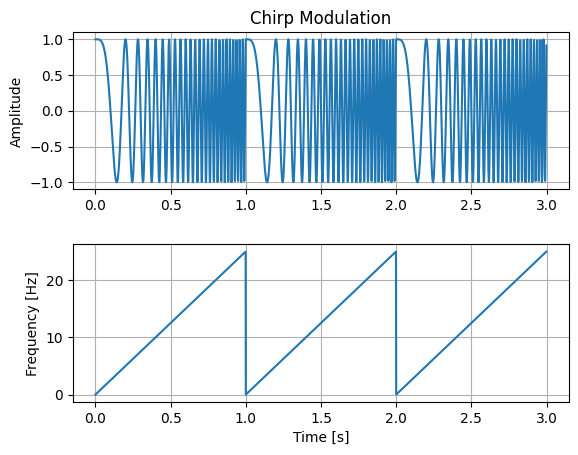

In [3]:
fmin      = 0             # frecuencia inicial del chirp [Hz]
fmax      = 25            # frecuencia final del chirp [Hz]
T         = 1             # tiempo de barrido de f0 a f1 [s]
Nchirps   = 3             # cantidad de chirps a generar
Nsamples  = 1000*Nchirps  # cantidad de muestras para la señal

t = np.arange(0,T*Nchirps,(T*Nchirps+1)/Nsamples) # vector de tiempo

x_chirp,f = chirp(fmin,fmax,T,t)

plt.figure()
plt.subplot(2,1,1)
plt.title("Chirp Modulation")
plt.plot(t,x_chirp)
plt.grid()
plt.ylabel("Amplitude")

plt.subplot(2,1,2)
plt.plot(t,f)
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.grid()

plt.subplots_adjust(hspace=0.35)
plt.show()


En la modulación LoRa, a cada tiempo de símbolo (Ts) la frecuencia cambia a un valor fijo y comienza a crecer desde ahí, el valor al que brinca representa el símbolo del mensaje enviado. La cantidad de bits que se pueden codificar por símbolo viene dado por un parámetro ajustable llamado Spreading Factor (SF), por lo cual si este tiene un valor de N, el símbolo representa N bits y puede tener 2 elevado a la N posibles valores de frecuencia.

De esta forma, la modulación se extiende sobre todo el espectro dentro del ancho de banda.

El SF es usado para determinar la tasa de envío de símbolos Rs y el tiempo del símbolo Ts, como se muestran en la ecuaciones:

$$T_S = \frac{2^{SF}}{B}[seg]$$
y
$$R_S = \frac{1}{T_S} = \frac{B}{2^{SF}} [\frac{simbolos}{seg}]$$

Aumentar el bandwith hace la comunicación más rápida, ya que disminuye el tiempo de bit (Aumenta la capacidad de canal Sharon-Hartley). El aumento de SF vuelve más lenta la comunicación ya que aumenta el tiempo de bit, esto a pesar de que el símbolo transporta más bits.

Este tipo de modulacion se denominará de aquí en adelante ***Frequency Shift Chirp Modulation*** ya que la modulación de los símbolos se obtiene en el shifteo de la frecuencia inicial del chirp.

### Teorema Hartley-Shannon
Este teorema busca describir la capacidad de un canal en transmitir información.
$$ C = B \times log_2(1+\frac{S}{N}) $$

Las modulaciones de espectro expandido usualmente tienen un S/N bajo que puede ser menor a la unidad. Reacomodando el logaritmo se puede demostrar que B/C ≈ N/S, por lo cual se necesita un B muy grande para transferir un bit sin errores.

### Preambulo

El preambulo en un sistema de comunicaciones es un conjunto de simbolos que se envían antes de los símbolos de datos y cumple dos funciones principales: facilitar la sincronización entre el transmisor y el receptor, y permitir la detección de errores en la transmisión de datos.

En modulacion LoRa, existe una determinada estructura de trama de transmision. El preámbulo inicia con unos pulsos del tipo upchirp los cuales pueden variar en cantidad dependiendo de la programación dada.

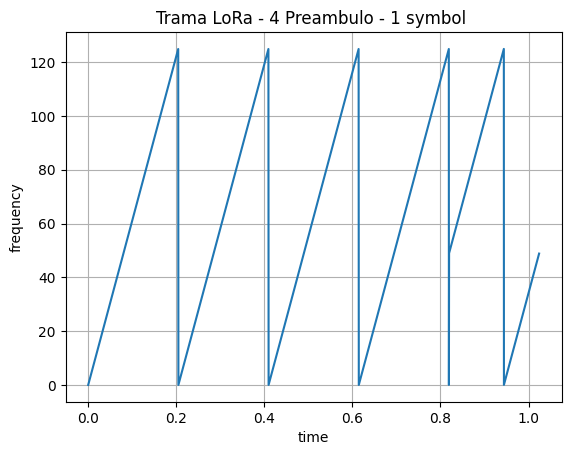

In [4]:
def generate_chirp(symbol, sf, Bw, t):
  """generate_chirp, genera la frecuencia de un chirp con frecuencia minima 0 y maxima 2**SF,
      pero esta shifteado, es decir su frecuencia en t=0 es symbol.
    Arguments:
        symbol  : simbolo a transmitir
        sf      : spreading factor
        Bw      : ancho de banda en kHz
        t       : vector de tiempo
    Returns:
        frec    : vector de frecuencias del chirp
  """

  Fmax = 2**sf            # frecuencia maxima del chirp
  Ts = Fmax/np.abs(Bw)    # Periodo de Simbolo. Ts=2^{SF}/Bw
  frec = []

  for i in range(len(t)):
    frec.append((symbol*np.abs(Bw)/Fmax + Bw/Ts*t[i]) % np.abs(Bw))

  return frec             # vector de frecuencia que varia linealmente con el tiempo

def generate_preamble(Nchirps, Bw, sf, Nsamples):
  """
  generate_preamble, genera los simbolos de preambulo (upchirps)
    Arguments:
        Nchirps   : cantidad de simbolos de preambulo
        Bw        : ancho de banda en kHz
        Nsamples  : cantidad de muestras por simbolo
        sf        : spreading factor
    Returns:
        preamble  : frecuencia de chirps de preambulo
  """
  f_0 = 0         # frecuencia inicial del chirp
  Ts = 2**sf/Bw   # tiempo de simbolo
  preamble = np.array([])
  t_chirp = np.linspace(0, Ts, Nsamples)

  for i in range(Nchirps):
    preamble = np.append(preamble, generate_chirp(f_0, sf, Bw,  t_chirp))

  return preamble


len_preamble  = 4
Bw            = 125
sf            = 7
sps           = 1000
Ts            = 2**sf/Bw
t             = np.linspace(0, Ts, sps)
symbol        = 50

preamble  = generate_preamble(len_preamble, Bw, sf, sps)
data      = generate_chirp(symbol, sf, Bw, t)

full_signal = np.concatenate((preamble,data))
full_t      = np.linspace(0, Ts, len(full_signal))

plt.figure()
plt.title("Trama LoRa - "+str(len_preamble)+" Preambulo - 1 symbol ")
plt.plot(full_t,full_signal)
plt.ylabel("frequency")
plt.xlabel("time")
plt.grid()


In [5]:
def waveform_chirp_time(symbols, sf, Bw, delta, sps):
  """
  waveform_chirp_time, genera la forma de onda LoRa para un simbolo dado.
    Arguments:
        symbols   : simbolos a transmitir
        sf        : spreading factor
        Bw        : ancho de banda en kHz
        delta     : delta de tiempo (discreto) entre muestras
        Nsamples  : cantidad de muestras por simbolo

    Returns:
        signal    : forma de onda LoRa
  """
  T = 1 / Bw  # Tiempo de muestra. Delta de tiempo en el cual se toma una muestra.

  wf = np.zeros(len(symbols) * sps, dtype=complex)

  for i in range(len(symbols)):
        k = (np.arange(sps)*delta + symbols[i]) % 2**sf  # arranca en el simbolo y va sumando delta hasta llegar a 2**sf donde vuelve a 0
        f = k * Bw / (2**sf)
        t = k * T

        samples = (1 / (np.sqrt(2**sf))) * np.exp(1j * 2 * np.pi * f * t * 1 / 2)
        wf[i*sps:(i+1)*sps] = samples

  return wf

def pream_sync(len_preamble, symbols, Bw, sf, sps, delta):
  """
  pream_sync, genera la señal a transmitir con preambulo, sincronizacion y datos
    Arguments:
        len_preamble: cantidad de chirps de preambulo
        symbols     : arreglo de simbolos a transmitir
        Bw          : ancho de banda en kHz
        sf          : spreading factor
        sps         : samples per symbol
        delta       : delta de tiempo (discreto) entre muestras
    Returns:
        full_signal : señal a transmitir (preambulo + sincronizacion + datos)
  """

  # Se generan las formas de onda de cada parte de la señal

  # parte de datos            - modulacion LoRa
  data_signal = waveform_chirp_time(symbols, sf, Bw, delta, sps)

  # parte de preambulo        - upchirp
  preamb_signal = waveform_chirp_time(np.zeros(len_preamble), sf, Bw, delta, sps)

    # full_signal = preambulo + sincronizacion + datos
  full_signal = np.array([])
  full_signal = np.append(full_signal, preamb_signal)
  full_signal = np.append(full_signal, data_signal)

  return full_signal

  def base_down_chirp(sf, Bw, delta):
    """
    base_down_chirp: genera el downchirp para la demodulacion LoRa
      Arguments:
          sf: spreading factor
          Bw: ancho de banda
          delta: espaciado entre frecuencias
      Returns:
          downchirp_t: downchirp en tiempo
          downchirp_f: frecuencia del downchirp
    """

    k = np.arange(2**sf, 0, -delta)
    f = k * Bw / (2**sf)                # frecuencias del downchirp
    t = k * 1 / Bw                      # tiempo del downchirp

    downchirp = (1 / (np.sqrt(2**sf))) * np.exp(-1j * 2 * np.pi * f * t * 1 / 2)

    return downchirp, f

### Frequency Shift Chirp Modulation (FSCM)

Dado un canal de ancho de banda B se transmite un simbolo cada $T = 1/B$.
El simbolo $s(nT_s)$ es enviado al modulador cada un periodo $T_s=2^{SF}
\times T$ ($Ts$ = Periodo entre simbolos y $T$ = Periodo entre muestras, un simbolo tiene muchas muestras).
El simbolo es un valor real formado con un vector $w(nT_s)$ de SF valores binarios donde SF es un entero llamado Spreading Factor.

 $$ s(nT_{s})=∑_{h=0}^{SF-1} w(nT_s)_h · 2^h $$

Entonces el simbolo toma valores de 0 hasta $2^{SF}-1$.
La forma de onda transmitida de duracion $T_S$ para un cierto  $s(nT_S)$ es:
$$c(nT_{s}+kT)={1\over \sqrt{2^{SF}}} e^{j2\pi[(s(nT_s)+k) \mod {2^{SF}}]kT{B\over 2^{SF}}} $$
$$\hspace{2.35cm}={1\over \sqrt{2^{SF}}} e^{j2\pi[(s(nT_s)+k) \mod {2^{SF}}]{k\over 2^{SF}}} $$

para $k$ = $0\ldots2^{SF}-1$

Si se compara con:
$$f(t) = \alpha e^{j2\pi ft}$$
Se tiene que:
  - $f$ : ${(s(nT_s) + k)\mod2^{SF}}\frac{B}{2^{SF}} $
  - $t$ : $kT$
  - $\alpha$ : $\frac{1}{\sqrt{2^{SF}}}$

La señal modulada es una forma de onda tipo chirp donde la frecuencia aumenta linealmente con $k$ que es el indice de tiempo.
Cada forma de onda arranca en un valor distinto de frecuencia, es por eso que se denomina Frequency Shift Chirp Modulation (FCSM).

Las formas de onda que se generan con los simbolos, forman una base ortogonal, es decir:
$$\langle c(nT_s+kT)|_{s(nT_s)=i}\hspace{1mm},\hspace{1mm}c(nT_s+kT)|_{s(nT_s)=q}\rangle = 0$$
$$i \not= q, i,q \in \{0,...,2^{SF}-1\}$$

In [6]:
def loraMod(symbols,SF,samplingRate):
  # Shift Chirp Modulation for N symbols
  #
  # Parameters:
  #   - symbols : simbolos a transmitir, puede ser {0,...,2^SF-1}
  #   - SF      : spreading factor
  #   - samplingRateW      : sampling rate
  #
  # Returns:
  #   - signal  : frequency shifted chirp modulated signal
  #   - frec    : vector de frecuencia

  Tm = 1/samplingRate

  k = np.arange(0,2**SF,Tm)

  sps = 2**SF*samplingRate
  lora_signal = np.zeros(sps * len(symbols))

  freq = np.zeros(lora_signal.size)

  for i in range(len(symbols)):
    symbol = symbols[i]
    frec = (( symbol + k ) % 2**SF ) * 1 / (2**SF)
    lora_signal[i*sps:(i+1)*sps] = complex_exp(frec,k)
    freq[i*sps:(i+1)*sps] = frec

  return lora_signal,freq

C:\Users\juanm\AppData\Local\Temp\ipykernel_9812\2231233061.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  lora_signal[i*sps:(i+1)*sps] = complex_exp(frec,k)


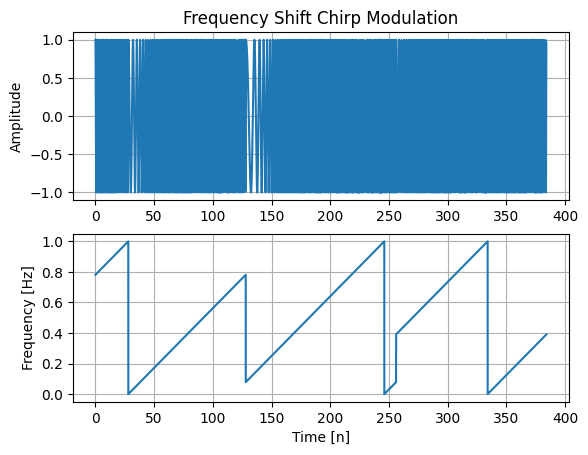

In [7]:
SF      = 7              # spreading factor
symbols = [100, 10, 50]          # simbolos a transmitir, posibles simbolos son {0,1,2,2^(SF)-1}

samplingRate = 30
signal,frec = loraMod(symbols,SF,samplingRate)

t = np.linspace(0, 2**SF*len(symbols), signal.size)

plt.figure()

plt.subplot(2,1,1)
plt.title("Frequency Shift Chirp Modulation")
plt.plot(t,signal)
plt.grid()
plt.ylabel("Amplitude")

plt.subplot(2,1,2)
plt.plot(t,frec)
plt.grid()
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [n]")

tx_signal = signal

## Demodulacion LoRa

### Optimum detection of FSCM signals in AWGN channels

La señal recibida es:

$$r(nT_s+kT) = c(nT_s+kT) + w(nT_s+kT)$$

donde $w$ representa el ruido gaussiano blanco que tiene media zero y varianza independiente del tiempo.
El demodulador optimo consiste en proyectar la señal recibida sobre las diferentes señales de base, y elegir la señal de base tal que el cuadrado del modulo de la proyecion es el maximo, esto se da porque el producto interno de la misma señal es la energia. Asi se obtendria el mejor estimador del simbolo transmitido.

Aplicando el desarrollo del paper la proyeccion:
$$<r(nT_s+kT),c(nT_s+kT)|_{s(nT_s)=q}> = $$
$$ = \sum_{k=0}^{2^{SF}-1} r(nT_s+kT) c^*(nT_s+kT)|_{s(nT_s)=q} $$
$$\hspace{3.85cm} = \sum_{k=0}^{2^{SF}-1} r(nT_s+kT) e^{-j2\pi \frac{k^2}{2^{SF}}} \frac{1}{\sqrt{2^{SF}}} e^{-j2\pi[(q+k) \mod 2^{SF-k}]\frac{k}{2^{SF}}} $$

Si comparamos con la transfomada discreta de fourier:

$$X_p = \sum_{k=0}^{N-1} x_n e^{-\frac{2j\pi}{N} p k }$$

Se observa que:
- $x_n = r(nT_s+kT) e^{-j2\pi \frac{k^2}{2^{SF}}} \frac{1}{\sqrt{2^{SF}}}$
- $ N = 2^{SF}$
- $ p= (q+k) \mod 2^{SF-k} $

Por lo que la demodulacion consiste en dos pasos:

  1. Multiplicar la señal recibida muestra a muestra por la señal $e^{-j2 \pi \frac{k^2}{2^{SF}}}$ (un downchirp).
  2. Obtener la transformada discreta de fourier del resultado anterior y seleccionando el valor en el indice p.

El simbolo estimado sera aquel que de un mayor valor en el indice p.

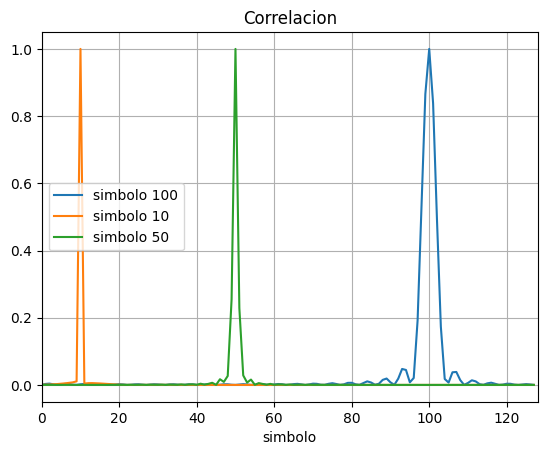

In [8]:
rx_signal = tx_signal
sps = 2**SF*samplingRate
t_rx = t[0:sps]                   # tomo elemento de t desde 0 hasta (sps-1)

# paso 1 - multiplicar por downchirp
k2 = t_rx**2                      # tiempo al cuadrado
const = -1/(2**SF)                # constante
downchirp = complex_exp(k2,const) # down chirp base

simbolos_estimados = []

plt.figure()
plt.title("Correlacion")
plt.grid()
plt.xlim([0,2**SF])
plt.xlabel("simbolo")
legends = []

# paso 2 - correlacion y seleccion de indice de mayor valor

for i in range(len(rx_signal[0::sps])): # recorro la cantidad de simbolos que hay
  rx = rx_signal[i*sps:(i+1)*sps]       # tomo las muestras correspondientes a un simbolo
  rx_mult = rx*downchirp
  rx_fft = abs(np.fft.fft(rx_mult)[0:2**SF])**2 # realizo la Transformada de Fourier rapida
  simbolo_estimado = np.argmax(rx_fft)  # selecciono el indice que me da el mayor valor

  simbolos_estimados.append(simbolo_estimado)

  plt.plot(rx_fft/max(abs(rx_fft)))
  legends.append(f"simbolo {simbolo_estimado}")

plt.legend(legends)


## Canal

### Additive White Gaussian Noise (AWGN)

Se modela como parte del canal el agregado de ruido blanco gaussiano dentro de la señal. Este ruido es de media 0 y varianza $\sigma^2$.

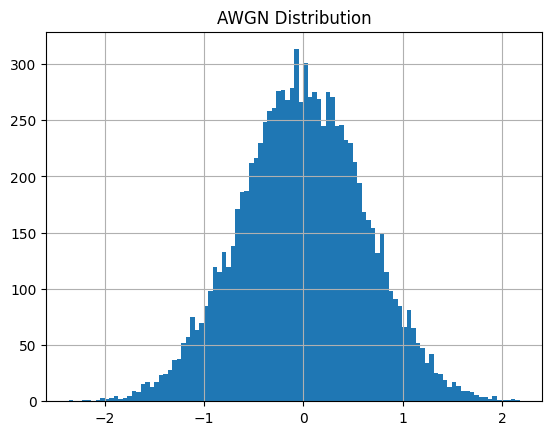

In [9]:
sigma2 = 0.4              # varianza
sigma  = np.sqrt(sigma2)  # desviación estandar
media = 0
noise = np.random.normal(media,sigma,10000)

plt.figure()
plt.title("AWGN Distribution")
plt.hist(noise,bins=100)
plt.grid()

### Path Loss

#### Modelo Okumura

El modelo de Okumura es uno de los más ampliamente utilizados para predicción de señales en áreas urbanas. Este modelo es aplicable para frecuencias en el rango de 150 a 1920 MHz, es decir, comprende la banda de VHF y UHF (sin embargo, típicamente es Extrapolado para frecuencias arriba de 3000 MHz entrando en la banda de SHF) y distancias de 1 Km a 100 Km, además puede ser usado para alturas de la antena de la estación en el rango de 30 m a 1000 m.
Okumura desarrolló un conjunto de curvas que dan la atenuación mediana relativa al espacio libre (Amu ) para una zona urbana sobre un terreno casi plano, con una altura de la antena de la estación base (hte) de 200 m y una altura de antena móvil (ℎ𝑟𝑒) de 3m.
Para determinar la pérdida de trayectoria utilizando el modelo de Okumura se expresa de la siguiente manera:
$$L_{50}dB = LF + A_{mu}(f,d) - G_{hte} -G_{hre}-G_{AREA}$$

$L_{50}dB \Rightarrow $ Pérdidas por propagación al 50% de recepción de la señal.

$LF \Rightarrow $ Perdidas en el espacio libre.

$A_{mu} \Rightarrow $ Atenuacion media relativa a las pérdidas en el espacio libre.

$G_{hte} \Rightarrow $ Factor de ganancia de la antena transmisora (dB)

$G_{hre} \Rightarrow $ Factor de ganancia de la antena receptora (dB)

$G_{AREA} \Rightarrow $ Factor de corrección que depende del entorno

El modelo de Okumura es uno de los más simples y prácticos en términos de precisión en la predicción de pérdida de trayectoria y se ha convertido en un estándar de planificación de sistemas de radio móviles terrestres modernos en Japón.

#### Modelo Hata (Okumura-Hata)

Desarrollado por Masaharu Hata en 1980 y basado en los resultados de las mediciones realizadas por Yoshihisa Okumura en la ciudad de Tokio, Japón, consiste en un conjunto de ecuaciones que permite estimar las pérdidas de propagación en diferentes tipos de zonas (urbana, semiurbana y rural). Es uno de los modelos más utilizados en la planificación y dimensionamiento del segmento de propagación de sistemas inalámbricos de telecomunicaciones, incluyendo los sistemas TDA. El modelo trata de representar las mediciones hechas por Okumura a través de la forma:

$$(A+B)log_{10}R$$

Donde:

**A** y **B** Son funciones de la frecuencia y la altura de la antena

**R** Es la distancia entre la antena y el usuario.

Con el objetivo de hacer que este método fuera más fácil de aplicar, Hata estableció una serie de relaciones numéricas que describen el método gráfico propuesto por Okumura.

Dividiendo las áreas de predicción categorizadas por el tipo de terreno, llamadas área abierta, urbana y suburbana.

**Área urbana:** Corresponde a las grandes ciudades con altas edificaciones y casas con 2 o más pisos, o donde existen una gran concentración de casas.

$$ {\displaystyle L_{50}(urbano)=69.55+26.16log(f_{c})-13.82log(h_{te})-a(h_{re})+(44.9-6.55log(h_{te}))log(d)} $$

Tomando en cuenta:
$${\displaystyle 150Mhz<f_{c}<1500Mhz}$$
$${\displaystyle 30m<h_{te}<200m}$$
$${\displaystyle 1m<h_{re}<10m} $$

Donde:

${\displaystyle f_{c}}$ Frecuencia portadora. [MHz]

${\displaystyle h_{te}}$ Altura de la antena transmisora [m], en rango de 30 a 200 m.

${\displaystyle h_{re}}$ Altura de la antena receptora [m], en rango de 1 a 10 m.

${\displaystyle a(h_{re})}$ Factor de corrección para la altura efectiva de la antena móvil que es función del tipo de área de servicio.

$d$ Distancia entre transmisor y receptor [Km].

El factor de corrección de la antena del móvil $a(hre)$ se define según el tamaño de la ciudad:

Para frecuencias mayores a 300MHz:
$${\displaystyle a(h_{re})=3.2(log(11.75 · h_{re}))^{2}-4.97[dB]}$$

**Área rural:** Son los espacios abiertos sin grandes árboles o edificaciones en el camino de la señal.
$${\displaystyle L(dB)=L_{50}(urbano)-4.78(log(f_{c}))^{2}+18.33log(f_{c})-40.94} $$


Text(0.5, 0, '[km]')

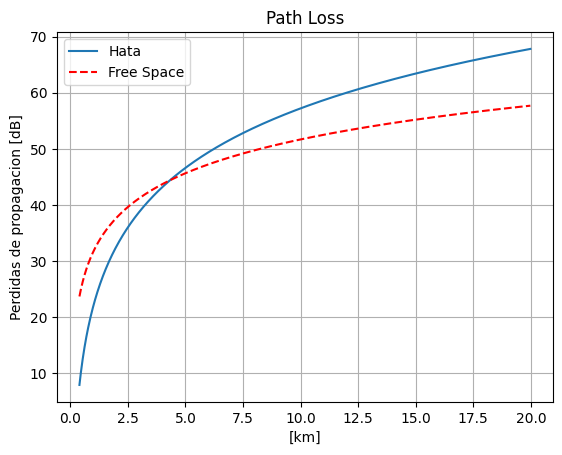

In [10]:
Nsamples = 1000                     # cantidad de muestras para la señal
dis = np.arange(0.4,20,20/Nsamples) # vector de distancia
fc = 915*(10**6)                    # portadora [Hz] (frecuencia libre Argentina)
lmda = 300000000 / fc               # longitud de onda [m]
hte = 30                            # altura antena transmisora [m]
hre = 2                             # altura antena receptor    [m]

# Factor de corrección para la altura efectiva de la antena
Alpha = 3.2*(np.log10(11.75*hre))**2 - 4.97 # [dB] corresponde a f mayores a 300Mhz

# Pérdidas por propagación al 50% de recepción de la señal urbana
L_50_urbano = 69.55 + 26.16*np.log10(fc) - 13.82*np.log10(hte) - Alpha + (44.9-6.55*np.log10(hte))*np.log10(dis) # [dB]

# Pérdidas por propagación de recepción de la señal rural apartir de ecuacion urbana
L_rural = L_50_urbano - 4.78*(np.log10(fc))**2 + 18.33*np.log10(fc) - 40.94     # [dB]

# L_rural = constante en [dB] ==>  Relacion de potencia = Psal/Pentrada = P(entrante al receptor)/P(que sale del transmisor) [VECES]
# Relacion de potencia = 10 log ( Psal/Pentrada ) [dB] (Esta relacion es + (si hay ganancia) ó - (si hay atenuación))
# Relacion de potencia Constante si la distancia es fija (esta relacion esta dada por hata)

# segun el bixio, la perdida de espacio libre (free space path loss) Apendice 3.11
L_free_space = 10*np.log10((4*np.pi*dis/lmda)**2)  # [dB]

plt.figure()
plt.title("Path Loss")
plt.plot(dis,L_rural)
plt.plot(dis, L_free_space, '--r')
plt.grid()
plt.legend(["Hata", "Free Space"])
plt.ylabel("Perdidas de propagacion [dB]")
plt.xlabel("[km]")



Podemos observar que a medida que aumenta la distancia entre la antena transmisora y la antena receptora existe un mayor incremento de la perdida de propagacion de la señal. Tambien se ve que esa perdida, con el incremento de los km, será mayor en el modelo de hata que en el modelo free space,lo cual es bastante logico ya que este tiene en cuenta la altura de las antenas y el otro no.

## Simulador

Con lo desarrollado anteriormente se procede a modelar en python el transmisor, canal y receptor. A traves de este simulador se obtienen las métricas de bit error rate, con las cuales se pueden obtener curvas de BER vs SNR y ver como estas se desplazan al modificar los paramentros de la comunicacion.

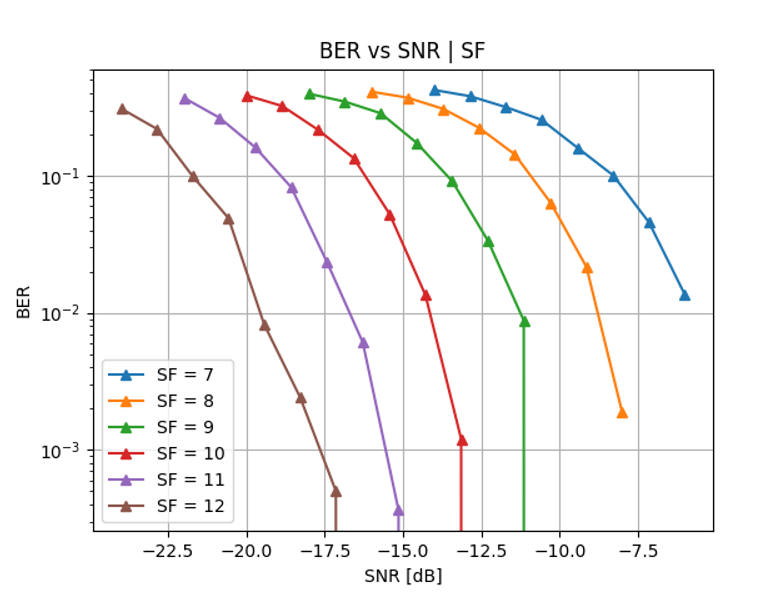

<small>Aclaracion: por los recursos limitados que ofrece google colab y por que las funciones no estan optimizadas al maximo, no se pueden desarrollar simulaciones demasiado exigentes ya que toman mucho tiempo, pero se puede copiar el codigo y ejecutarlo en una maquina mas potente.</small>

Podemos observar que a medida que la SNR disminuye, osea que se va haciendo mas negativa, el BER comienza a incrementar. Notamos que al aumentar el spreading factor el rendimiento mejora, lo que significa que a mayor spreading factor la SNR que necesaria para tener un BER aceptable es menor.

### Funciones

#### Transmisor

Conformado por las siguientes funciones:

- generate_symbols: genera simbolos aleatorios
- waveform_chirp_time: crea la forma de onda LoRa (frequency shifted chirp modulation)
- pream_sync: crea la trama a transmitir constituida por un preambulo y datos

In [11]:
def generate_symbols(sf, Nsymbols):
  """
  generate_symbols, genera los simbolos aleatorios a transmitir
    Arguments:
        sf        : spreading factor
        Nsymbols  : cantidad de simbolos a transmitir
    Returns:
        symbols   : arreglo de simbolos a transmitir
  """

  symbols = np.random.randint(0, 2**sf,Nsymbols)    # Arreglo de simbolos a transmitir aleatorios en {0, 2**SF-1}

  return np.array(symbols)


In [12]:
def waveform_chirp_time(symbols, sf, Bw, delta, sps):
  """
  waveform_chirp_time, genera la forma de onda LoRa para un simbolo dado.
    Arguments:
        symbols   : simbolos a transmitir
        sf        : spreading factor
        Bw        : ancho de banda en kHz
        delta     : delta de tiempo (discreto) entre muestras
        Nsamples  : cantidad de muestras por simbolo

    Returns:
        signal    : forma de onda LoRa
  """
  T = 1 / Bw  # Tiempo de muestra. Delta de tiempo en el cual se toma una muestra.

  wf = np.zeros(len(symbols) * sps, dtype=complex)

  for i in range(len(symbols)):
        k = (np.arange(sps)*delta + symbols[i]) % 2**sf  # arranca en el simbolo y va sumando delta hasta llegar a 2**sf donde vuelve a 0
        f = k * Bw / (2**sf)
        t = k * T

        samples = (1 / (np.sqrt(2**sf))) * np.exp(1j * 2 * np.pi * f * t * 1 / 2)
        wf[i*sps:(i+1)*sps] = samples

  return wf

In [13]:
def pream_sync(len_preamble, symbols, Bw, sf, sps, delta):
  """
  pream_sync, genera la señal a transmitir con preambulo, sincronizacion y datos
    Arguments:
        len_preamble: cantidad de chirps de preambulo
        symbols     : arreglo de simbolos a transmitir
        Bw          : ancho de banda en kHz
        sf          : spreading factor
        sps         : samples per symbol
        delta       : delta de tiempo (discreto) entre muestras
    Returns:
        full_signal : señal a transmitir (preambulo + sincronizacion + datos)
  """

  # Se generan las formas de onda de cada parte de la señal

  # parte de datos            - modulacion LoRa
  data_signal = waveform_chirp_time(symbols, sf, Bw, delta, sps)

  # parte de preambulo        - upchirp
  preamb_signal = waveform_chirp_time(np.zeros(len_preamble), sf, Bw, delta, sps)

  # full_signal = preambulo + sincronizacion + datos
  full_signal = np.array([])
  full_signal = np.append(full_signal, preamb_signal)
  full_signal = np.append(full_signal, data_signal)

  return full_signal

#### Canal

El canal se divide en 2 funciones:


*   hata_path_loss: realiza las estimaciónes de las pérdidas por propagación de la recepción de la señal en areas rurales. Tambien se analizan a modo de comparación las perdidas por propagacion en espacio libre.
*   awgn_channel: recibe la señal modulada, añade el ruido gaussiano blanco y las perdidas por propagación vistas en el modelo de Hata-Okumura. Esto se hace para simular el paso de la señal por el canal.



In [14]:
def hata_path_loss(hre, hte, fc, dis):
    """Hata Path Loss Model
    Arguments:
        hre: altura antena receptora [m]
        hte: altura antena transmisora [m]
        fc: frecuencia de portadora [Hz]
        dis: distancia entre antenas [m]
    Returns:
        L_rural: pérdidas por propagación de la señal en ambiente rural [veces]
    """
    # Factor de corrección para la altura efectiva de la antena
    Alpha = (
        3.2 * (np.log10(11.75 * hre)) ** 2 - 4.97
    )  # [dB] corresponde a f mayores a 300Mhz

    # Pérdidas por propagación al 50% de recepción de la señal urbana
    L_50_urbano = (
        69.55
        + 26.16 * np.log10(fc)
        - 13.82 * np.log10(hte)
        - Alpha
        + (44.9 - 6.55 * np.log10(hte)) * np.log10(dis)
    )  # [dB]

    # Pérdidas por propagación de recepción de la señal rural apartir de ecuacion urbana
    L_rural = (
        L_50_urbano - 4.78 * (np.log10(fc)) ** 2 + 18.33 * np.log10(fc) - 40.94
    )  # [dB]

    return 10 ** (L_rural / 10)

In [15]:
def free_space_path_loss(fc, dis):
    """Free Space Path Loss Model
    Arguments:
        fc: frecuencia de portadora [Hz]
        dis: distancia entre antenas [m]
    Returns:
        perdida por propagacion en espacio libre [veces]
    """
    return (4 * np.pi * dis * fc / 3e8) ** 2

In [16]:
def awgn_channel(config: dict):
    """Additive White Gaussian Noise Channel
    Arguments:
        config: {
                signal: señal a transmitir
                snr_db: snr en db
                hre: altura antena receptora [m]
                hte: altura antena transmisora [m]
                fc: frecuencia de portadora [Hz]
                dis: distancia entre antenas [m]
            }
    Returns:
        out: {
                signal: señal afectada por el canal
            }
    """

    ch_input = config["signal"]
    snr_db = config["snr_db"]
    hre = config["hre"]
    hte = config["hte"]
    fc = config["fc"]
    dis = config["dis"]

    # ruido AWGN
    Ptx = np.var(ch_input)                  # potencia transmitida [veces]

    Ls = hata_path_loss(hre, hte, fc, dis)  # perdidas por propagacion [veces]

    snr = 10 ** (snr_db / 10)               # snr en veces

    sigma2 = Ptx * Ls / snr                 # varianza del ruido (N0)

    # ruido AWGN complejo
    sigma = np.sqrt(sigma2 / 2)             # desviación estandar
    # la potencia se divide en parte real mas parte imaginaria
    noise = np.random.normal(0, sigma, len(ch_input)) + 1j * np.random.normal(
        0, sigma, len(ch_input)
    )

    ch_out = ch_input + noise

    out = {"signal": ch_out}

    return out


#### Receptor

Conformado por 3 funciones:

- base_down_chirp: genera el downchirp por el cual se debe multiplicar la señal recibida

- lora_demapper: convierte los simbolos a bits

- demodulate_waveform: demodula la señal recibida multiplicando primero por el downchirp y despues tomando el argumento maximo de la transformada rapida de fourier de ese producto

In [17]:
def base_down_chirp(sf, Bw, delta):
    """
    base_down_chirp: genera el downchirp para la demodulacion LoRa
      Arguments:
          sf: spreading factor
          Bw: ancho de banda
          delta: espaciado entre frecuencias
      Returns:
          downchirp_t: downchirp en tiempo
          downchirp_f: frecuencia del downchirp
    """

    k = np.arange(2**sf, 0, -delta)
    f = k * Bw / (2**sf)                # frecuencias del downchirp
    t = k * 1 / Bw                      # tiempo del downchirp

    downchirp = (1 / (np.sqrt(2**sf))) * np.exp(-1j * 2 * np.pi * f * t * 1 / 2)

    return downchirp, f

In [18]:
def lora_demapper(symbols: list, SF: int):
    """Lora Symbol Demapper
    Arguments:
        symbols: simbolos recibidos
        SF     : spreading factor
    Returns:
        bits: bits recibidos
    """
    bits = []
    for symbol in symbols:
        bits.extend([int(x) for x in bin(symbol)[2:].zfill(SF)]) # pasa de entero a binario mediante una concatenación
    return np.array(bits)

In [19]:
def demodulate_waveform(rx_signal, sf, Bw, delta, sps, len_preamb_sync):
    """
    demodulate_waveform: demodula la señal recibida
      Arguments:
          rx_signal       : señal recibida
          sf              : spreading factor
          Bw              : ancho de banda
          delta           : espaciado entre frecuencias
          sps             : muestras por simbolo
          len_preamb_sync : cantidad de simbolos del preambulo
      Returns:
          symbols         : simbolos estimados
          corrs           : correlaciones con la base
    """
    data_signal = rx_signal[len_preamb_sync * sps :]  # parte de la señal que contiene los simbolos transmitidos.
                                                      # se evita hacer deteccion de preambulo para agilizar la simulacion, [ver LoRa SDR para implementacion]

    # demodulacion
    downchirp, _ = base_down_chirp(sf, Bw, delta)

    downchirp = downchirp[0::int(1/delta)]              # downchirp de 2**sf muestras

    lora_mod_symbols = data_signal[0::int(1/delta)]     # señal recibida de 2**sf donde cada simbolo tiene 2**sf muestras

    cantidad_simbolos_recibidos = int(len(data_signal) / sps)

    corrs = []      # Matriz
    symbols = []

    for i in range(cantidad_simbolos_recibidos):

        lora_mod_symbol = lora_mod_symbols[i * 2**sf : (i+1) * 2**sf ]  # un simbolo

        dechirped_symbol = lora_mod_symbol * downchirp                  # dechirped symbol

        corr = abs(np.fft.fft(dechirped_symbol))                        # correlacion usando la fft

        symbol = np.argmax(corr)                                        # estimacion del simbolo

        corrs.append(corr)
        symbols.append(symbol)


    return symbols, corrs

#### Funcion completa

Esta función utiliza todas las funciones anteriormente definidas para lograr el recorrido completo desde la generación del simbolo, la modulación de la señal y el paso por el canal, hasta la recepción de la señal en donde se demodula y se calcula el BER para ser analizado posteriormente.

In [20]:
def lora_sim(config):
    """Lora Tranceiver Simulation
    Arguments:
        config: {
                    sf                  : spreading factor
                    Bw                  : ancho de banda
                    Nsymbols            : numero de simbolos a transmitir
                    delta               : paso entre frecuencias
                    sps                 : muestras por simbolo
                    len_preamb          : cantidad de simbolos del preambulo

                    snr_db              : snr en db
                    hre                 : altura antena receptora [m]
                    hte                 : altura antena transmisora [m]
                    fc                  : frecuencia de portadora [Hz]
                    dis                 : distancia entre antenas [m]
                    Nbits               : cantidad de bits a transmitir
                }
    Returns:
        out:    {
                    ber: bit error rate
                }
    """
    sf          = config["sf"]          # Spreading factor. varia entre [7-12]
    Bw          = config["Bw"]          # Khz. Ancho de banda definido para la transmision. varia entre 125 o 250 o 500 [Khz]
    Nsymbols    = config["Nsymbols"]    # numero de datos a transmitir
    delta       = config["delta"]       # paso entre muestras
    sps         = config["sps"]         # Samples per symbol
    len_preamb  = config["len_preamb"]  # Tamaño del preambulo
    snr_db      = config["snr_db"]      # snr en db
    hre         = config["hre"]         # altura antena receptor    [m]
    hte         = config["hte"]         # altura antena transmisora [m]
    fc          = config["fc"]          # portadora [Hz] (frecuencia libre Argentina)
    dis         = config["dis"]         # distancia entre antenas [km]



    # --------------- TRANSMISOR ---------------
    if Nsymbols > 1:
      symbols  = generate_symbols(sf, Nsymbols) # symbs son los datos generados aleatoriamente, data_tx son los chirp en frecuencia
    elif Nsymbols == 1:
      symb= 20
      symbols = [symb]

    tx_signal = pream_sync(len_preamb, symbols, Bw, sf, sps, delta)


    # --------------- CANAL ---------------
    ch_out = awgn_channel(
        {
            "signal"  : tx_signal ,
            "snr_db"  : snr_db    ,
            "hte"     : hte       ,
            "hre"     : hre       ,
            "fc"      : fc        ,
            "dis"     : dis
        }
    )

    rx_signal = ch_out["signal"]


    # --------------- RECEPTOR ---------------
    rx_symbols, _ =   demodulate_waveform(rx_signal, sf, Bw, delta, sps, len_preamb)

    # symbol to bits
    sent_bits       = lora_demapper(symbols, sf)
    received_bits   = lora_demapper(rx_symbols, sf)

    # bit error rate
    errors = sum(abs(sent_bits - received_bits))
    ber = errors / len(sent_bits)

    out = {"ber": ber}

    return out

## Simulaciones

Procedemos a realizar 2 simulaciones en las cuales se busca variar un parametro de la comunicación para ver como se comporta el BER vs SNR. Estos parametro son:


*   Spreading Factor: nos da la relación entre la velocidad de datos y el ancho de banda utilizado para transmitir la señal
*   Distancia entre antenas: la distancia que existe entre la antena transmisora y receptora.



### Curvas de BER vs SNR con SF variable

SF =  7
	SNR:  -13.0  dB  | BER:  0.39
	SNR:  -12.0  dB  | BER:  0.34
	SNR:  -11.0  dB  | BER:  0.29
	SNR:  -10.0  dB  | BER:  0.21
	SNR:  -9.0  dB  | BER:  0.14
	SNR:  -8.0  dB  | BER:  0.08
	SNR:  -7.0  dB  | BER:  0.04
SF =  8
	SNR:  -15.0  dB  | BER:  0.37
	SNR:  -14.0  dB  | BER:  0.32
	SNR:  -13.0  dB  | BER:  0.24
	SNR:  -12.0  dB  | BER:  0.18
	SNR:  -11.0  dB  | BER:  0.11
	SNR:  -10.0  dB  | BER:  0.06
	SNR:  -9.0  dB  | BER:  0.02
SF =  9
	SNR:  -17.0  dB  | BER:  0.33
	SNR:  -16.0  dB  | BER:  0.27
	SNR:  -15.0  dB  | BER:  0.2
	SNR:  -14.0  dB  | BER:  0.14
	SNR:  -13.0  dB  | BER:  0.07
	SNR:  -12.0  dB  | BER:  0.02
	SNR:  -11.0  dB  | BER:  0.01
SF =  10
	SNR:  -19.0  dB  | BER:  0.34
	SNR:  -18.0  dB  | BER:  0.24
	SNR:  -17.0  dB  | BER:  0.17
	SNR:  -16.0  dB  | BER:  0.1
	SNR:  -15.0  dB  | BER:  0.04
	SNR:  -14.0  dB  | BER:  0.01
	SNR:  -13.0  dB  | BER:  0.0
SF =  11
	SNR:  -21.0  dB  | BER:  0.28
	SNR:  -20.0  dB  | BER:  0.2
	SNR:  -19.0  dB  | BER:  0.11
	SNR:

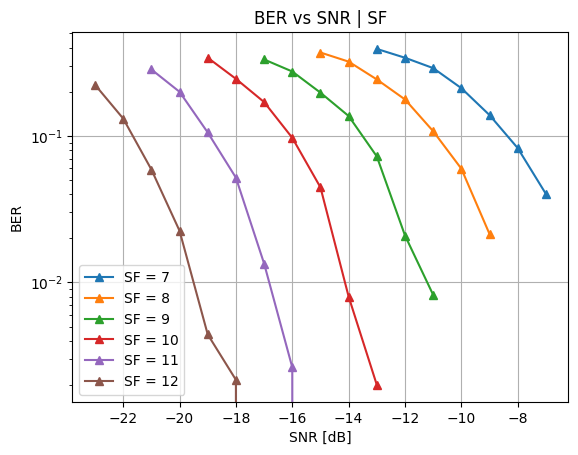

In [21]:
# Configuracion del Simulador
sf    = 7
Bw    = 125
delta = 1
sim_config_new = {
    "sf"          : sf                , # Spreading factor. varia entre [7-12]
    "Bw"          : Bw                , # Khz. Ancho de banda definido para la transmision. varia entre 125 o 250 o 500 [Khz]
    "Nsymbols"    : 1000              , # numero de datos a transmitir
    "delta"       : delta             , # delta entre muestras
    "sps"         : int(2**sf*1/delta), # Samples per symbol
    "len_preamb"  : 4                 , # Tamaño del preambulo
    "snr_db"      : -10               , # snr en db
    "hte"         : 30                , # altura antena transmisora [m]
    "hre"         : 10                , # altura antena receptor    [m]
    "fc"          : int(915e6)        , # portadora [Hz] (frecuencia libre Argentina)
    "dis"         : 0.5               , # distancia entre antenas [km]
}

# curvas de BER vs SNR barriendo SF
sfs = np.arange(7, 13)  # spreading factors {7-10}
data = []
for j in range(len(sfs)):
    sf = sfs[j]
    snrs = np.linspace(-13 - j * 2, -7 - j * 2, 7)  # snrs en db
    bers = []
    sim_config_new["sf"]    = sf
    sim_config_new["sps"]   = int(2**sf*1/delta)
    print("SF = ",sf)
    for i in range(len(snrs)):
        sim_config_new["snr_db"] = snrs[i]
        out = lora_sim(sim_config_new)
        bers.append(out["ber"])
        print("\tSNR: ", round(snrs[i],2), " dB"," | BER: ",round(out["ber"], 2))

    data.append({"snrs": snrs, "sf": sf, "bers": bers})

# graficar
plt.figure()
plt.title("BER vs SNR | SF")
plt.grid()
for i in range(len(data)):
    snrs = data[i]["snrs"]
    bers = data[i]["bers"]
    plt.semilogy(snrs, bers, "^-")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.legend(["SF = " + str(sf) for sf in sfs])
plt.show()

Podemos observar que a medida que la SNR disminuye, ósea que se va haciendo más negativa, el BER comienza a incrementar. Notamos que al aumentar el spreading factor el rendimiento mejora, lo que significa que a mayor spreading factor la SNR que se necesita para tener un BER aceptable es menor.
También se tiene en cuenta que al aumentar el SF se utilizan más bits para representar cada símbolo y esto aumenta el tiempo requerido para transmitirlos, pero también reduce la cantidad de errores en la comunicación.


### Curvas de BER vs SNR con Distancia Variables

distancia:  0.4
	SNR:  -20.0  dB  | BER:  0.32
	SNR:  -17.33  dB  | BER:  0.13
	SNR:  -14.67  dB  | BER:  0.01
	SNR:  -12.0  dB  | BER:  0.0
distancia:  0.48
	SNR:  -20.0  dB  | BER:  0.44
	SNR:  -17.33  dB  | BER:  0.33
	SNR:  -14.67  dB  | BER:  0.13
	SNR:  -12.0  dB  | BER:  0.01
distancia:  0.55
	SNR:  -20.0  dB  | BER:  0.46
	SNR:  -17.33  dB  | BER:  0.43
	SNR:  -14.67  dB  | BER:  0.31
	SNR:  -12.0  dB  | BER:  0.1
distancia:  0.62
	SNR:  -20.0  dB  | BER:  0.49
	SNR:  -17.33  dB  | BER:  0.47
	SNR:  -14.67  dB  | BER:  0.4
	SNR:  -12.0  dB  | BER:  0.25
distancia:  0.7
	SNR:  -20.0  dB  | BER:  0.49
	SNR:  -17.33  dB  | BER:  0.48
	SNR:  -14.67  dB  | BER:  0.45
	SNR:  -12.0  dB  | BER:  0.36


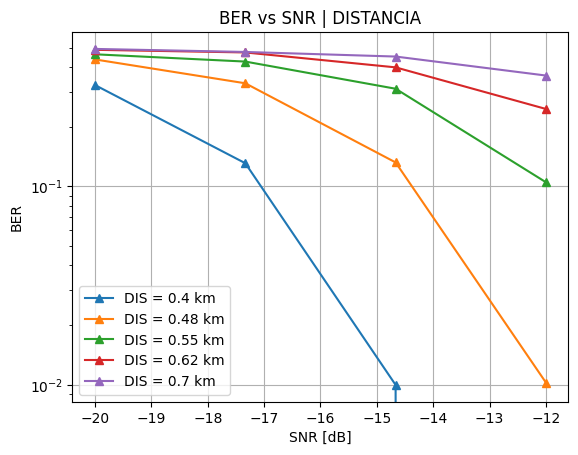

In [22]:
# Configuracion del Simulador
sf    = 9
Bw    = 125
delta = 1
sim_config_new = {
    "sf"          : sf                , # Spreading factor. varia entre [7-12]
    "Bw"          : Bw                , # Khz. Ancho de banda definido para la transmision. varia entre 125 o 250 o 500 [Khz]
    "Nsymbols"    : 2000              , # numero de datos a transmitir
    "delta"       : delta             , # delta entre muestras
    "sps"         : int(2**sf*1/delta), # Samples per symbol
    "len_preamb"  : 4                 , # Tamaño del preambulo
    "snr_db"      : -10               , # snr en db
    "hte"         : 30                , # altura antena transmisora [m]
    "hre"         : 10                , # altura antena receptor    [m]
    "fc"          : int(915e6)        , # portadora [Hz] (frecuencia libre Argentina)
    "dis"         : 0.5               , # distancia entre antenas [km]
}

# curvas de BER vs SNR barriendo la distancia entre transmisor y receptor
distancias = np.linspace(0.4,0.7,5)  # tres distancias consideradas
snrs = np.linspace(-20, -12, 4)             # snrs en db
data = []

for j in range(len(distancias)):
    bers = []
    sim_config_new["dis"] = distancias[j]
    print("distancia: ",round(distancias[j],2))
    for i in range(len(snrs)):
        sim_config_new["snr_db"] = snrs[i]
        out = lora_sim(sim_config_new)
        bers.append(out["ber"])
        print("\tSNR: ", round(snrs[i],2), " dB", " | BER: ",round(out["ber"], 2))

    data.append({"snrs": snrs, "dis": distancias[j], "bers": bers})

# graficar
plt.figure()
plt.title("BER vs SNR | DISTANCIA")
plt.grid()
for i in range(len(data)):
    snrs = data[i]["snrs"]
    bers = data[i]["bers"]
    plt.semilogy(snrs, bers, "^-")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.legend(["DIS = " + str(round(dis,2)) + " km" for dis in distancias])
plt.show()

En el grafico se observa la relación entre el BER y la SNR, se van fijando distintas distancias entre transmisor y receptor para dibujar las curvas. En conclusión observamos en ellas que a distancias más grandes entre el transmisor y el receptor, mayor será la SNR necesaria para lograr que el BER sea menor. Entonces si nosotros no podemos variar la distancia entre el nodo y el Gateway, tendremos que aumentar la potencia de transmisión si queremos una menor tasa de errores.


##Conclusión

Por lo visto en la sección de simulaciones se llega a la conclusión de que en una situación de área rural a campo abierto, para tener buena comunicación entre los nodos separados una distancia de alrededor 500 metros del gateway, se recomienda un spreading factor lo más alto posible (superior a 9 al menos) de forma de hacer el sistema más robusto al ruido y tener una comunicacion fiable.

Aumentar el spreading factor manteniendo el ancho de banda implica un tiempo de símbolo superior, esto en el ámbito de las comunicaciones de iot para medir variables del tipo temperatura o humedad, no es crítico ya que no tienen una velocidad de cambio significativa.

Esta modulación del tipo LoRa resulta especialmente útil en el caso de que tengamos por ejemplo un sensor, el cual no es necesario que tome mediciones a intervalos muy cortos de tiempo, debido a que la variable que sensa no cambia su valor de manera instantánea sino que varía en intervalos de tiempo grandes por ejemplo temperatura, humedad.
La implementación de un sistema IoT en el cual se realice la comunicación de los datos sensados con una modulación de tipo LoRa trae ventajas como el largo alcance para su bajo consumo y desventajas como que puede incurrir en un error de transmisión y recepción, si no es correctamente configurado y colocado.

## Bibliografia


- L. Vangelista, "Frequency Shift Chirp Modulation: The LoRa Modulation," in IEEE Signal Processing Letters, vol. 24, no. 12, pp. 1818-1821, Dec. 2017, doi: 10.1109/LSP.2017.2762960.
- O. Afisiadis, M. Cotting, A. Burg and A. Balatsoukas-Stimming, "On the Error Rate of the LoRa Modulation With Interference," in IEEE Transactions on Wireless Communications, vol. 19, no. 2, pp. 1292-1304, Feb. 2020, doi: 10.1109/TWC.2019.2952584.
- Principles of Digital Communications, Bixio Rimoldi
- Video: [How LoRa modulation really works](https://www.youtube.com/watch?v=jHWepP1ZWTk&t=403s )
- https://medium.com/pruebas-de-laboratorio-de-la-modulaci%C3%B3n-lora/modulaci%C3%B3n-lora-4ad74cabd59e
- https://en.wikipedia.org/wiki/Chirp
- https://es.wikipedia.org/wiki/Modelo_de_Okumura
- https://www.frugalprototype.com/wp-content/uploads/2016/08/an1200.22.pdf
- https://github.com/neon-iot
